In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Read the data
X = pd.read_csv("Input/train.csv", index_col='Id') 
X_test = pd.read_csv("Input/test.csv", index_col='Id')

# Remove rows with missing target, separate target from predictors
X.dropna(axis=0, subset=['SalePrice'], inplace=True)
y = X.SalePrice
X.drop(['SalePrice'], axis=1, inplace=True)

# To keep things simple, we'll drop columns with missing values
cols_with_missing = [col for col in X.columns if X[col].isnull().any()] 
X.drop(cols_with_missing, axis=1, inplace=True)

cols_with_missing = [col for col in X_test.columns if X_test[col].isnull().any()] 
X_test.drop(cols_with_missing, axis=1, inplace=True)

# Break off validation set from training data
X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                      train_size=0.8, test_size=0.2,
                                                      random_state=0)


In [2]:
#analysis of the depend valiable - SalePrice
# import seaborn as sns
# sns.displot(y_train,bins=30)


In [3]:
#bootstrap random column indexes
import random
def randomize(sample,n):
    return(random.sample(sample,n))

In [4]:
#Encode columns with low cardinality and drop columns with high cardinality
from sklearn.preprocessing import OneHotEncoder

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

OHE = OneHotEncoder(handle_unknown='ignore',sparse=False)
cols_obj = [col for col in X_train.columns if X_train[col].dtype=='object']
cols_obj_low_card = [col for col in X_train[cols_obj].columns if X_train[col].nunique()<10]
cols_obj_high_card = [col for col in X_train[cols_obj].columns if X_train[col].nunique()>=10]

# print(X_train[cols_obj_low_card].head())
OHX_train = pd.DataFrame(OHE.fit_transform(X_train[cols_obj_low_card]))
OHX_train.columns = OHE.get_feature_names()
OHX_train.index=X_train[cols_obj_low_card].index

# print(OHX_train.head())

# print(X_valid[cols_obj_low_card].head())
OHX_valid= pd.DataFrame(OHE.transform(X_valid[cols_obj_low_card]))
OHX_valid.columns = OHE.get_feature_names()
OHX_valid.index = X_valid[cols_obj_low_card].index
#print(OHX_valid.head())



In [5]:
from sklearn.preprocessing import StandardScaler 
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

stdsc = StandardScaler() 

## prepare training set
cols_number = [col for col in X_train if X_train[col].dtype!='object']
dfX_train_std = pd.DataFrame(stdsc.fit_transform(X_train[cols_number]))
dfX_train_std.index=X_train[cols_number].index
dfX_train_std.columns=X_train[cols_number].columns
dfX_train=pd.concat([dfX_train_std,OHX_train], axis=1)

dfX_valid_std = pd.DataFrame(stdsc.transform(X_valid[cols_number]))
dfX_valid_std.index = X_valid[cols_number].index
dfX_valid_std.columns = X_valid[cols_number].columns
dfX_valid=pd.concat([dfX_valid_std,OHX_valid], axis=1)


print(dfX_train.shape, dfX_valid.shape)

num_features = len(dfX_train.columns)
sample=list(range(0,num_features))
min_mae=100000
for j in range(num_features,num_features+1):   
    for repeat in range(1):
        #select j-random samples from samples
        #selector=randomize(sample,j) 
        selector = sample
        columns_selected = dfX_train.columns
        #select the features from the train set
        select_index=[True if i in selector else False for i in range(num_features)]
        X_train_final = dfX_train.loc[:,select_index]
        #X_train_std=dfX_train.loc[:,select_index]
        
        #select the features from the validation set
        select_index=[True if i in selector else False for i in range(num_features)]
        X_valid_final=dfX_valid.loc[:,select_index]
        #X_valid_std=dfX_valid.loc[:,select_index]
        
        model = RandomForestRegressor(n_estimators=155,random_state=0,max_depth=30)
        model.fit(X_train_final,y_train)
        preds = model.predict(X_valid_final)
        mae = mean_absolute_error(y_valid, preds)
        if mae<min_mae:
            min_mae=mae
            best_features = selector
        print(j,min_mae,len(best_features), best_features)
           
#Bruteforce best_features = [5, 20, 6, 22, 2, 29, 4, 3, 1, 10, 27, 19, 7, 9, 17, 33, 24, 23, 14, 12, 18, 25, 11, 28, 26, 30, 21, 13]

(1168, 155) (292, 155)
155 17249.100022094568 155 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154]


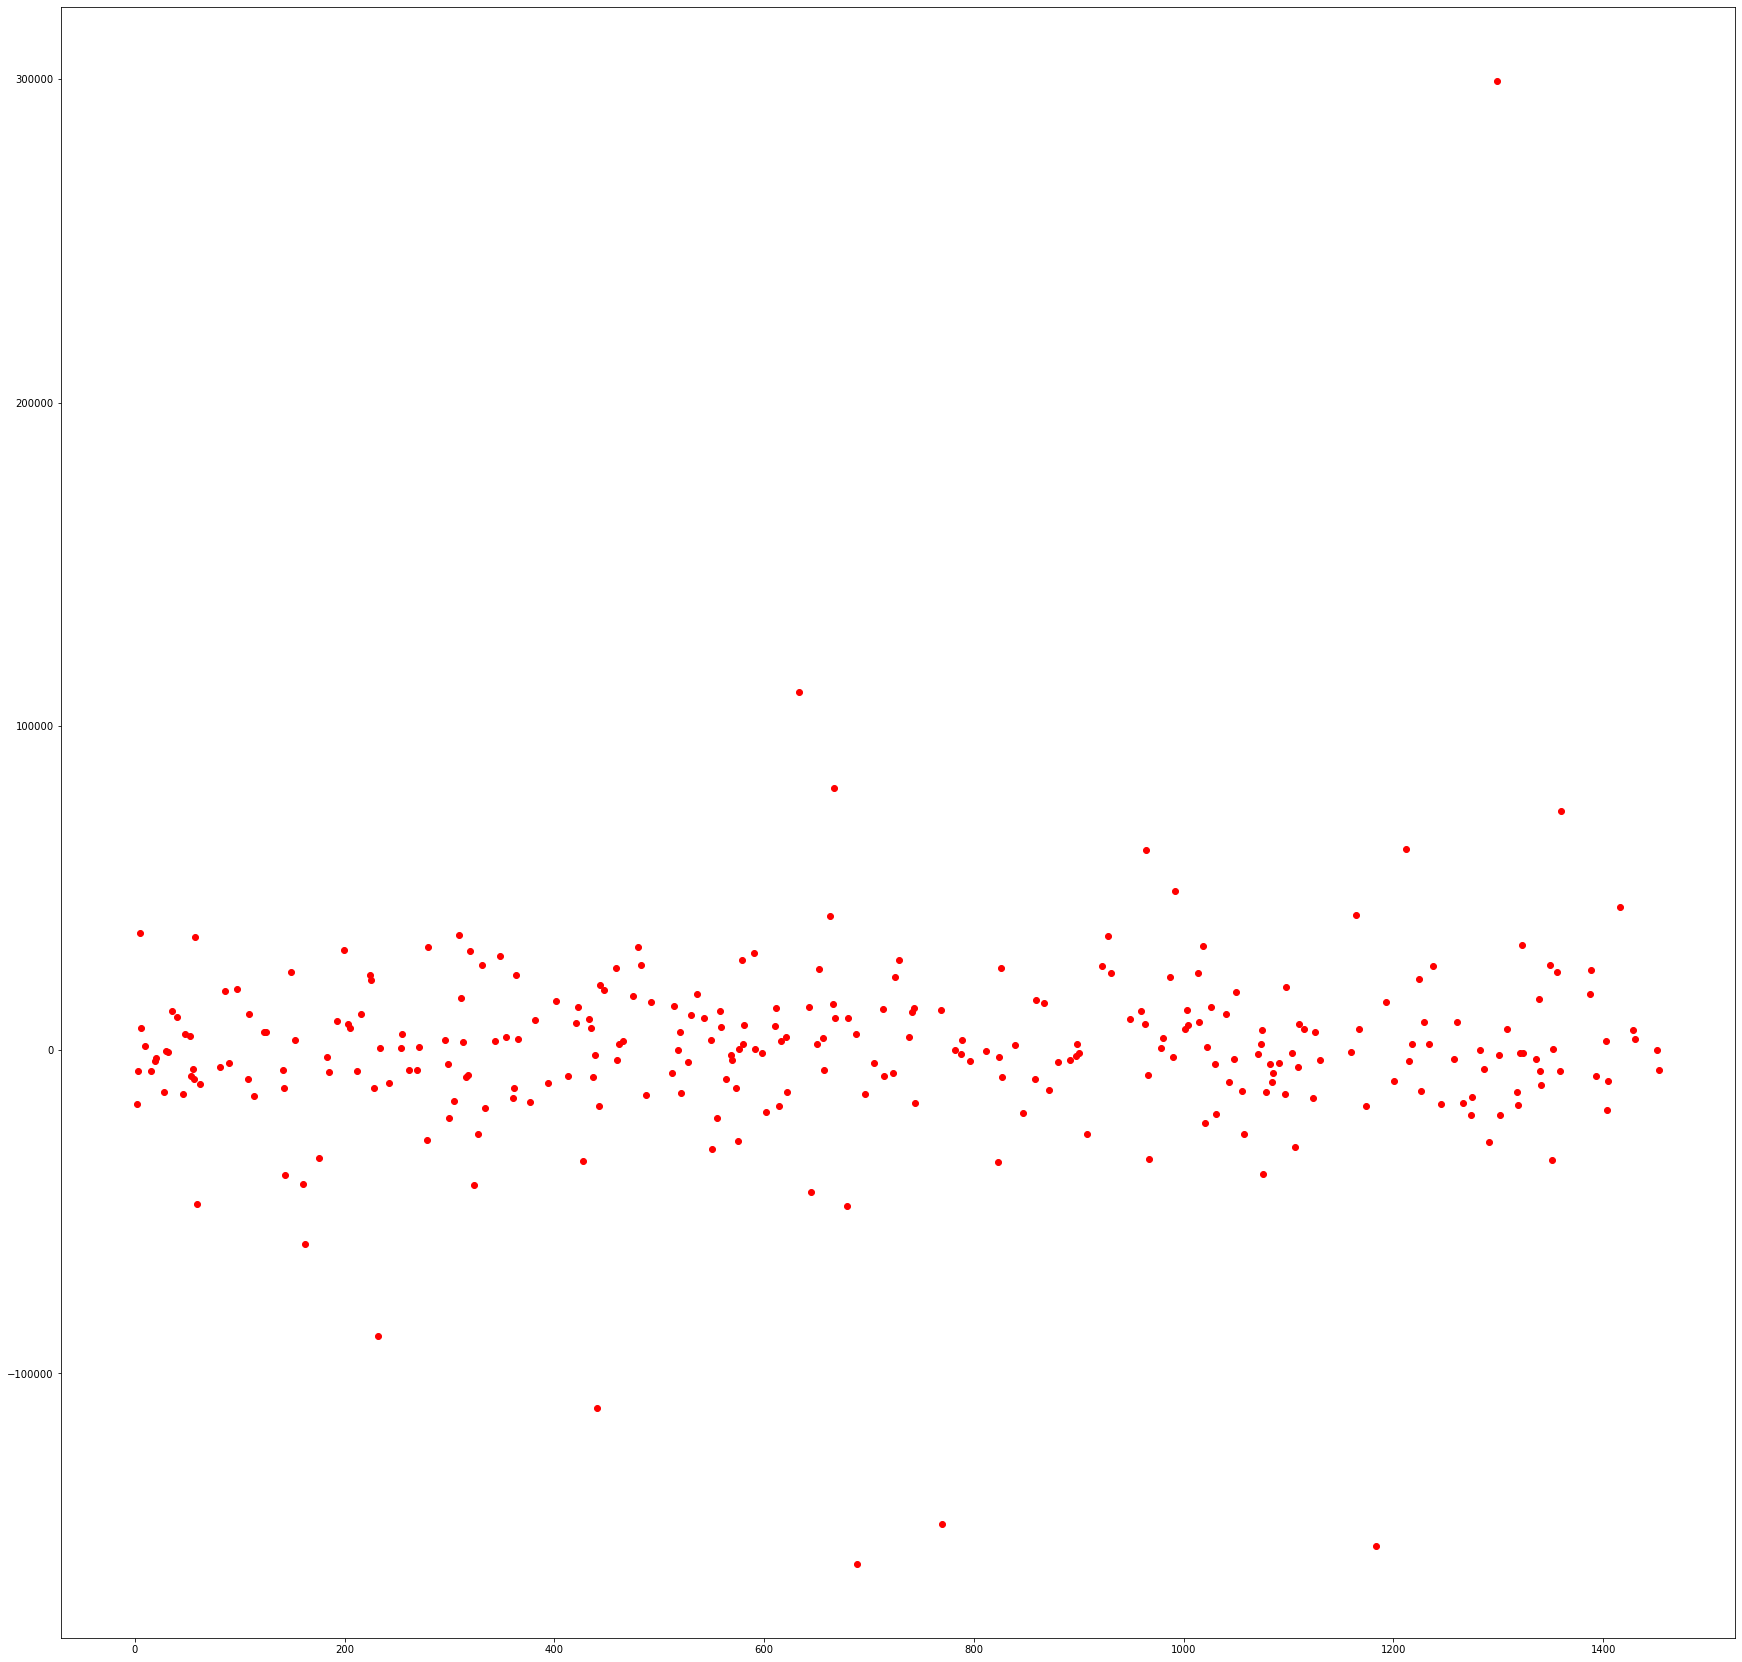

In [6]:
#plot predictions vs validation labels
df_compare = pd.DataFrame(y_valid)
df_compare['predictions'] = preds
df_compare['error'] = df_compare['predictions']-df_compare['SalePrice']
df_compare.sort_values(by='SalePrice',ascending=False,inplace=True)
# print(df_compare)
plt.figure(figsize=(30,30))
# sns.set(font_scale=2)
# sns.lineplot(x=df_compare.index, y= df_compare['SalePrice'])
# sns.lineplot(x=df_compare.index, y='predictions', data=df_compare, marker='o', linestyle='', err_style='bars')

#point plots for the prediction vs real price
# plt.plot(df_compare.index,df_compare['SalePrice'], 'bo', label='actual')
# plt.plot(df_compare.index,df_compare['prediction'], 'ro', label='prediction')
plt.plot(df_compare.index, df_compare['error'] , 'ro', label='error')
#plt.savefig('prediction.png', format='png', dpi=1200)
#sns.pointplot(x=df_compare.index, y= df_compare['predictions'],color='red')
plt.show()

# Create a heatmap to visualize the correlation of features to target
y_train.index=X_train.index
max=np.max(y_train)
min=np.min(y_train)
dfY_scaled = y_train*2/(max-min)-1
sel = [True if i<(num_features) else False for i in range(0,num_features)]
df_heatmap = pd.concat([X_train_final.loc[:,sel],dfY_scaled],axis=1)
cov_mat =np.cov(df_heatmap.T)
plt.figure(figsize=(180,180))
sns.set(font_scale=0.1)
hm = sns.heatmap(cov_mat,
                 cbar=True,
                 annot=True,
                 square=True,
                 fmt='.2f',
                 annot_kws={'size': 1},
                 cmap='coolwarm',                 
                 yticklabels=df_heatmap.columns,
                 xticklabels=df_heatmap.columns)
plt.title('Covariance matrix showing correlation coefficients', size = 18)
plt.tight_layout()
plt.savefig('heatmap.png', format='png', dpi=1200)
plt.show()

# print scatter plot for variable correlation
sns.scatterplot(x=df_heatmap['YearBuilt'],y=dfY_scaled)
plt.title('scatter plot YearRemodAdd', size = 18)
plt.tight_layout()
plt.savefig('heatmap.png', format='png', dpi=1200)
plt.show()

In [7]:
#check feature importance in the model
importances = list(model.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(dfX_train.columns, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: OverallQual          Importance: 0.58
Variable: GrLivArea            Importance: 0.12
Variable: TotalBsmtSF          Importance: 0.05
Variable: BsmtFinSF1           Importance: 0.03
Variable: GarageArea           Importance: 0.03
Variable: LotArea              Importance: 0.02
Variable: 1stFlrSF             Importance: 0.02
Variable: 2ndFlrSF             Importance: 0.02
Variable: GarageCars           Importance: 0.02
Variable: YearBuilt            Importance: 0.01
Variable: YearRemodAdd         Importance: 0.01
Variable: BsmtUnfSF            Importance: 0.01
Variable: TotRmsAbvGrd         Importance: 0.01
Variable: WoodDeckSF           Importance: 0.01
Variable: OpenPorchSF          Importance: 0.01
Variable: MoSold               Importance: 0.01
Variable: MSSubClass           Importance: 0.0
Variable: OverallCond          Importance: 0.0
Variable: BsmtFinSF2           Importance: 0.0
Variable: LowQualFinSF         Importance: 0.0
Variable: BsmtFullBath         Importance: 0

# Save the tree as a png image
from sklearn.tree import export_graphviz
from sklearn.tree import export_graphviz
import pydot

tree_small = model.estimators_[20]
export_graphviz(tree_small, out_file = 'small_tree.dot', feature_names = columns_selected, rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file('small_tree.dot')
graph.write_png('small_tree.png');
print(columns_selected)

## Train the model
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
model = RandomForestRegressor(n_estimators=100,random_state=0)

model.fit(X_std,y_train)

#prepare the validation set in the same form
X_valid_df=(pd.DataFrame(X_valid[cols]))
selector = [2,9,10,13,20,23,33]
selector=list(range(0,34))
select_index=[True if i in selector else False for i in range(33)]

X_valid_std=stdsc.fit_transform(X_valid_df.loc[:,select_index])

#print(X_valid_std,X_std)

#make predictions and get the error
preds = model.predict(X_valid_std)
print(mean_absolute_error(y_valid, preds))